# Abstract

In order to analyze the financial feasibility of solar panels, electricity price, usage, and customer data was sourced from the U.S. Energy Information Administration (EIA). The original dataset obtained via API from the EIA was cleaned and restructured. Years 2015 and prior were dropped due to null values. Post cleaning, an ordinary least squares (OLS) regression model was fit on electricity price (cents per kWh) for the years between 2015 and 2025 to generate predictions for the next 30 years. The predicted electricity prices were then multiplied by the most recent average electricity usage per customer for the specific state and cumulatively summed (assuming average electricity usage would remain constant) for the future 30 year period. This calculation would serve as an estimated savings amount for individuals who opt to install a solar panel system.  

Calculating the cumulatively summed cost of electricity allows me to compare the estimated savings from a solar panel system to the return on investment if the same principal amount were put into the stock market (7% CAGR) using the compound interest formula FV = PV × (1 + r)ⁿ.

What was found in the study is that solar panel systems provide a significant return on investment through their energy savings, however, an investment in the S&P 500 with the ideal case of 7% CAGR generates a much larger ROI. Specifically for New Jersey a $20,000 dollar investment into a solar panel system with 100% electricity coverage provides an ROI of 189.82% over 30 years, where the S&P 500 provides an ROI of 661.23%. Due to the difference in ROI, installing solar panels as a financial investment should at most be considered as a method to diversify one's investment portfolio.  



# Introduction

In the following analysis I aim to answer whether or not photovoltaic technology (solar panels) is a sound financial investment for Americans. I will explore how the investment in solar panels compare to a more traditional investment such as investing in the American stock market via the S&P 500 (assuming a 7% compound annual growth rate (CAGR)), and will calculate estimated savings for a residential electricity customer given the solar system provides 100% electricity usage coverage. Using the up-front cost of a solar panel system I will compare the hypothetical return from an investment into the S&P 500 and the state-specific estimated savings calculated with the data retrieved from the U.S. EIA (Energy Information Administration).

URL to source of data:  [API Dashboard - U.S. Energy Information Administration (EIA)](https://www.eia.gov/opendata/browser/electricity/retail-sales?frequency=annual&data=customers;price;sales;&facets=stateid;sectorid;&stateid=AK;AL;AR;AZ;CA;CO;CT;DC;DE;FL;GA;HI;IA;ID;IL;IN;KS;KY;LA;MA;MD;ME;MI;MN;MO;MS;MT;NC;ND;NE;NH;NJ;NM;NV;NY;OH;OK;OR;PA;RI;SC;SD;TN;TX;UT;VA;VT;WA;WI;WV;WY;&sectorid=RES;&start=1990&end=2024&sortColumn=period;&sortDirection=desc;)

Photovoltaic technology is a developing industry with promising positive impacts on the environment, however, understanding from a financial perspective the impact installing a system will cause is an important consideration for all individual potential buyers. As the usage of solar panel systems continues to become more popular a clear understanding of the financial feasibility of installation is a key determining factor to explore.  



# Data Cleaning / Wrangling

#### Loading and Viewing Data

In [398]:
# Retail Electricity Data from EIA API 

import requests
import pandas as pd
import os

# Load API key from environment variable
api_key = os.getenv("EIA_API_KEY") 

# Base API URL
base_url = "https://api.eia.gov/v2/electricity/retail-sales/data/"

# Construct URL with hidden API key
params = {
    "api_key": api_key,
    "frequency": "annual",
    "data[0]": "customers",
    "data[1]": "price",
    "data[2]": "sales",
    "facets[stateid][]": ["AK", "AL", "AR", "AZ", "CA", "CO", "CT", "DC", "DE", "FL",
                           "GA", "HI", "IA", "ID", "IL", "IN", "KS", "KY", "LA", "MA",
                           "MD", "ME", "MI", "MN", "MO", "MS", "MT", "NC", "ND", "NE",
                           "NH", "NJ", "NM", "NV", "NY", "OH", "OK", "OR", "PA", "RI",
                           "SC", "SD", "TN", "TX", "UT", "VA", "VT", "WA", "WI", "WV", "WY"],
    "facets[sectorid][]": "RES",
    "start": 1990,
    "end": 2024,
    "sort[0][column]": "period",
    "sort[0][direction]": "desc",
    "offset": 0,
    "length": 5000
}

# Make API request
response = requests.get(base_url, params=params)

# Check API response status
if response.status_code == 200:
    json_data = response.json()
    electricity_df = pd.DataFrame(json_data['response']['data'])
    print(electricity_df.head())
else:
    print(f"Error: {response.status_code}")

  period stateid stateDescription sectorid   sectorName customers  price  \
0   2024      CA       California      RES  residential  14362038  31.86   
1   2024      NE         Nebraska      RES  residential    918007  11.74   
2   2024      MT          Montana      RES  residential    562914  12.67   
3   2024      MO         Missouri      RES  residential   2893876  12.91   
4   2024      MS      Mississippi      RES  residential   1352980  13.29   

         sales      customers-units              price-units  \
0  86123.50838  number of customers  cents per kilowatt-hour   
1  10384.57215  number of customers  cents per kilowatt-hour   
2   5742.79414  number of customers  cents per kilowatt-hour   
3  35758.05386  number of customers  cents per kilowatt-hour   
4  18854.13367  number of customers  cents per kilowatt-hour   

              sales-units  
0  million kilowatt hours  
1  million kilowatt hours  
2  million kilowatt hours  
3  million kilowatt hours  
4  million kilowat

In [399]:
# Summary statistics
electricity_df.describe()

,period,stateid,stateDescription,sectorid,sectorName,customers,price,sales,customers-units,price-units,sales-units
count,1224,1224,1224,1224,1224,561,1224,1224,1224,1224,1224
unique,24,51,51,1,1,561,780,1224,1,1,1
top,2024,CA,California,RES,residential,409668,11.27,44235.593,number of customers,cents per kilowatt-hour,million kilowatt hours
freq,51,24,24,1224,1224,1,7,1,1224,1224,1224


Here we can see there are some unneccessary variables - the units columns (right most three) only show what the units are for other variables, and so they will be dropped (their unit values added to the headers of the appropriate variable). The sectorid and sectorName will also be dropped as they show that the data loaded from the EIA represents only residential data. StateDescription will also be dropped as we will use the stateid variable to identifiy the states. 

#### Checking for Missing Values

In [400]:
# Checking for missing values
missing_values = electricity_df.isnull().sum()
print("Missing values in each column:")
print(missing_values)

Missing values in each column:
period                0
stateid               0
stateDescription      0
sectorid              0
sectorName            0
customers           663
price                 0
sales                 0
customers-units       0
price-units           0
sales-units           0
dtype: int64


#### Searching for patterns in the missing values

In [401]:
# Checking if all states have missing values
missing_states = electricity_df[electricity_df.isnull().any(axis=1)]
print(missing_states['stateid'].unique())

# Counting number of states with missing values
missing_count = missing_states['stateid'].nunique()
print(f"Number of states with missing values: {missing_count}")

['MO' 'AR' 'KY' 'MS' 'MN' 'MI' 'MA' 'MD' 'ME' 'LA' 'WI' 'WV' 'WA' 'VA'
 'WY' 'AZ' 'AL' 'KS' 'IA' 'VT' 'UT' 'TX' 'TN' 'SD' 'SC' 'AK' 'IN' 'RI'
 'PA' 'OR' 'OK' 'OH' 'ND' 'IL' 'ID' 'HI' 'GA' 'FL' 'NC' 'DC' 'DE' 'CT'
 'CO' 'CA' 'NY' 'NM' 'NJ' 'NH' 'NV' 'NE' 'MT']
Number of states with missing values: 51


In [402]:
# Checking unique years for which there is missing data
missing_years = missing_states['period'].unique()
print("Years with missing data:")
print(missing_years)

Years with missing data:
['2015' '2014' '2013' '2012' '2011' '2010' '2007' '2006' '2005' '2004'
 '2003' '2002' '2001']


The missing values in our data is correlated with specific years prior to 2016, this could be due to data recording practice changes in the EIA. Due to the amount of missing values (663 out of 1224) I will not imputate the values, and I will opt to drop years 2015 and prior to maintain the customer column's completeness, and accuracy of the data.  

#### Checking to see if all states appropriately contain the same year ranges and dropping years 2015 and prior

In [403]:
# Showing range of years for each state

# Convert 'period' to datetime
electricity_df['period'] = pd.to_datetime(electricity_df['period'], format='%Y')

# Extracting the year from the period
electricity_df['year'] = electricity_df['period'].dt.year

# Getting the range of years for each state
year_range = electricity_df.groupby('stateid')['year'].agg(['min', 'max']).reset_index()
year_range.columns = ['stateid', 'min_year', 'max_year']
print("Year range for each state:")
print(year_range)

Year range for each state:
   stateid  min_year  max_year
0       AK      2001      2024
1       AL      2001      2024
2       AR      2001      2024
3       AZ      2001      2024
4       CA      2001      2024
5       CO      2001      2024
6       CT      2001      2024
7       DC      2001      2024
8       DE      2001      2024
9       FL      2001      2024
10      GA      2001      2024
11      HI      2001      2024
12      IA      2001      2024
13      ID      2001      2024
14      IL      2001      2024
15      IN      2001      2024
16      KS      2001      2024
17      KY      2001      2024
18      LA      2001      2024
19      MA      2001      2024
20      MD      2001      2024
21      ME      2001      2024
22      MI      2001      2024
23      MN      2001      2024
24      MO      2001      2024
25      MS      2001      2024
26      MT      2001      2024
27      NC      2001      2024
28      ND      2001      2024
29      NE      2001      2024
30      NH  

In [404]:
# Dropping rows with year 2015 and prior
electricity_df = electricity_df[electricity_df['year'] > 2015]

#### Restructuring Dataframe

In [405]:
# Viewing column names
print(electricity_df.columns)

Index(['period', 'stateid', 'stateDescription', 'sectorid', 'sectorName',
       'customers', 'price', 'sales', 'customers-units', 'price-units',
       'sales-units', 'year'],
      dtype='object')


In [406]:
# renaming column headers to be more descriptive
electricity_df.rename(columns={
    'customers': 'number_of_customers',
    'price': 'price(cents/kWh)',
    'sales': 'sales_millions(kWh)',
}, inplace=True)

In [407]:
# Dropping unnecessary columns
electricity_df.drop(columns=['period', 'stateDescription', 'sectorid','sectorName','customers-units','price-units','sales-units'], inplace=True)

# Viewing cleaned dataframe
electricity_df.head()

,stateid,number_of_customers,price(cents/kWh),sales_millions(kWh),year
0,CA,14362038,31.86,86123.50838,2024
1,NE,918007,11.74,10384.57215,2024
2,MT,562914,12.67,5742.79414,2024
3,MO,2893876,12.91,35758.05386,2024
4,MS,1352980,13.29,18854.13367,2024


#### Checking data types of the dataframe

In [408]:
# Checking data types
print("Data types of each column:")
print(electricity_df.dtypes)

Data types of each column:
stateid                object
number_of_customers    object
price(cents/kWh)       object
sales_millions(kWh)    object
year                    int32
dtype: object


In [409]:
# Converting variables sales, customers, and price to numeric for visualization of data
electricity_df['sales_millions(kWh)'] = pd.to_numeric(electricity_df['sales_millions(kWh)'], errors='coerce')
electricity_df['number_of_customers'] = pd.to_numeric(electricity_df['number_of_customers'], errors='coerce')
electricity_df['price(cents/kWh)'] = pd.to_numeric(electricity_df['price(cents/kWh)'], errors='coerce')

# Converting stateid to string
electricity_df['stateid'] = electricity_df['stateid'].astype(str)

In [410]:
# Confirming data types after conversion
print("Data types of each column:")
print(electricity_df.dtypes)

Data types of each column:
stateid                 object
number_of_customers      int64
price(cents/kWh)       float64
sales_millions(kWh)    float64
year                     int32
dtype: object


# Exploratory Data Analysis

C:\Users\chung\AppData\Local\Temp\ipykernel_16292\3187155462.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, fontsize=10)
C:\Users\chung\AppData\Local\Temp\ipykernel_16292\3187155462.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, fontsize=10)
C:\Users\chung\AppData\Local\Temp\ipykernel_16292\3187155462.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, fontsize=10)


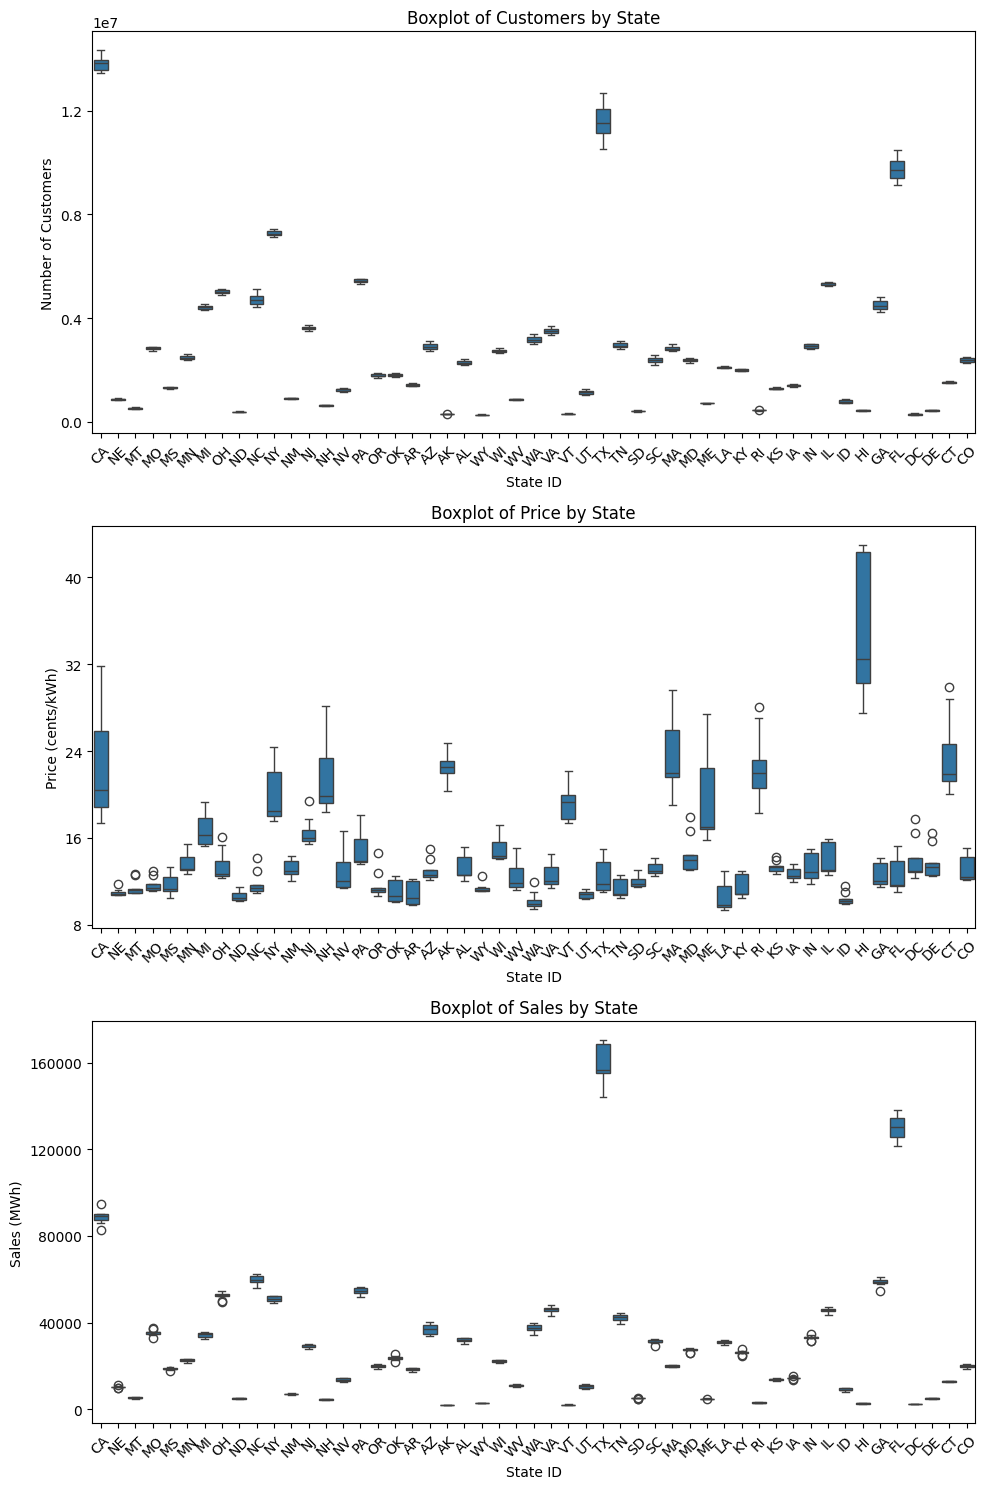

In [411]:
# Plotting boxplots for customers, price, and sales to check for outliers and view distribution

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.ticker as ticker

# Create a figure with subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

# Boxplot for customers
sns.boxplot(x='stateid', y='number_of_customers', data=electricity_df, ax=axes[0])
axes[0].set_title('Boxplot of Customers by State')
axes[0].set_xlabel('State ID')
axes[0].set_ylabel('Number of Customers')
axes[0].yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, fontsize=10)

# Boxplot for price
sns.boxplot(x='stateid', y='price(cents/kWh)', data=electricity_df, ax=axes[1])
axes[1].set_title('Boxplot of Price by State')
axes[1].set_xlabel('State ID')
axes[1].set_ylabel('Price (cents/kWh)')
axes[1].yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, fontsize=10)

# Boxplot for sales
sns.boxplot(x='stateid', y='sales_millions(kWh)', data=electricity_df, ax=axes[2])
axes[2].set_title('Boxplot of Sales by State')
axes[2].set_xlabel('State ID')
axes[2].set_ylabel('Sales (MWh)')
axes[2].yaxis.set_major_locator(ticker.MaxNLocator(nbins=5)) 
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, fontsize=10)

# Adjust layout
plt.tight_layout()
plt.show()

Shown above we can see box plots of sales, price, and customers seperated by state with circles representing outliers in the data. No outliers shown seem to be due to recording errors or irregularities so I will keep all data. What is notable here is that the states with the highest number of residential customers are not the states with the highest residential electricity sales, for example California has a greater amount of customers than Florida, however Florida had a higher amount of electricity sales likely due to climate conditions leading to greater electricity usage per capita. It is also notable here that all three measures are highly varied by state, some state's median are more than twice that of other states. Price has the greatest IQR spread out of the three measures. 

#### Price change over time

In [412]:
# Calculating price change over time by state
price_change = electricity_df.groupby('stateid').agg({'price(cents/kWh)': ['first', 'last']})
price_change['price_change'] = price_change['price(cents/kWh)']['first'] - price_change['price(cents/kWh)']['last']
price_change['price_change_percent'] = (price_change['price(cents/kWh)']['first'] - price_change['price(cents/kWh)']['last']) / price_change['price(cents/kWh)']['first'] * 100
price_change = price_change.reset_index()
price_change.columns = ['stateid', 'first_price', 'last_price', 'price_change', 'price_change_percent']
print("Price change over time by state:")
print(price_change)

Price change over time by state:
   stateid  first_price  last_price  price_change  price_change_percent
0       AK        24.71       20.30          4.41             17.847025
1       AL        15.12       11.99          3.13             20.701058
2       AR        12.24        9.92          2.32             18.954248
3       AZ        14.95       12.15          2.80             18.729097
4       CA        31.86       17.39         14.47             45.417451
5       CO        15.06       12.07          2.99             19.853918
6       CT        28.76       20.01          8.75             30.424200
7       DC        17.72       12.29          5.43             30.643341
8       DE        16.45       13.42          3.03             18.419453
9       FL        14.15       10.98          3.17             22.402827
10      GA        14.14       11.50          2.64             18.670438
11      HI        42.72       27.47         15.25             35.697566
12      IA        13.55       1

In [413]:
# Calculating average price change for all states
average_price_change_percent = price_change['price_change_percent'].mean()
average_price_change = price_change['price_change'].mean()
print(f"Average price change for all states: {average_price_change:.2f} cents/kWh")
print(f"Average price change for all states in percentage: {average_price_change_percent:.2f}%")

Average price change for all states: 3.86 cents/kWh
Average price change for all states in percentage: 20.51%


C:\Users\chung\AppData\Local\Temp\ipykernel_16292\827257871.py:9: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


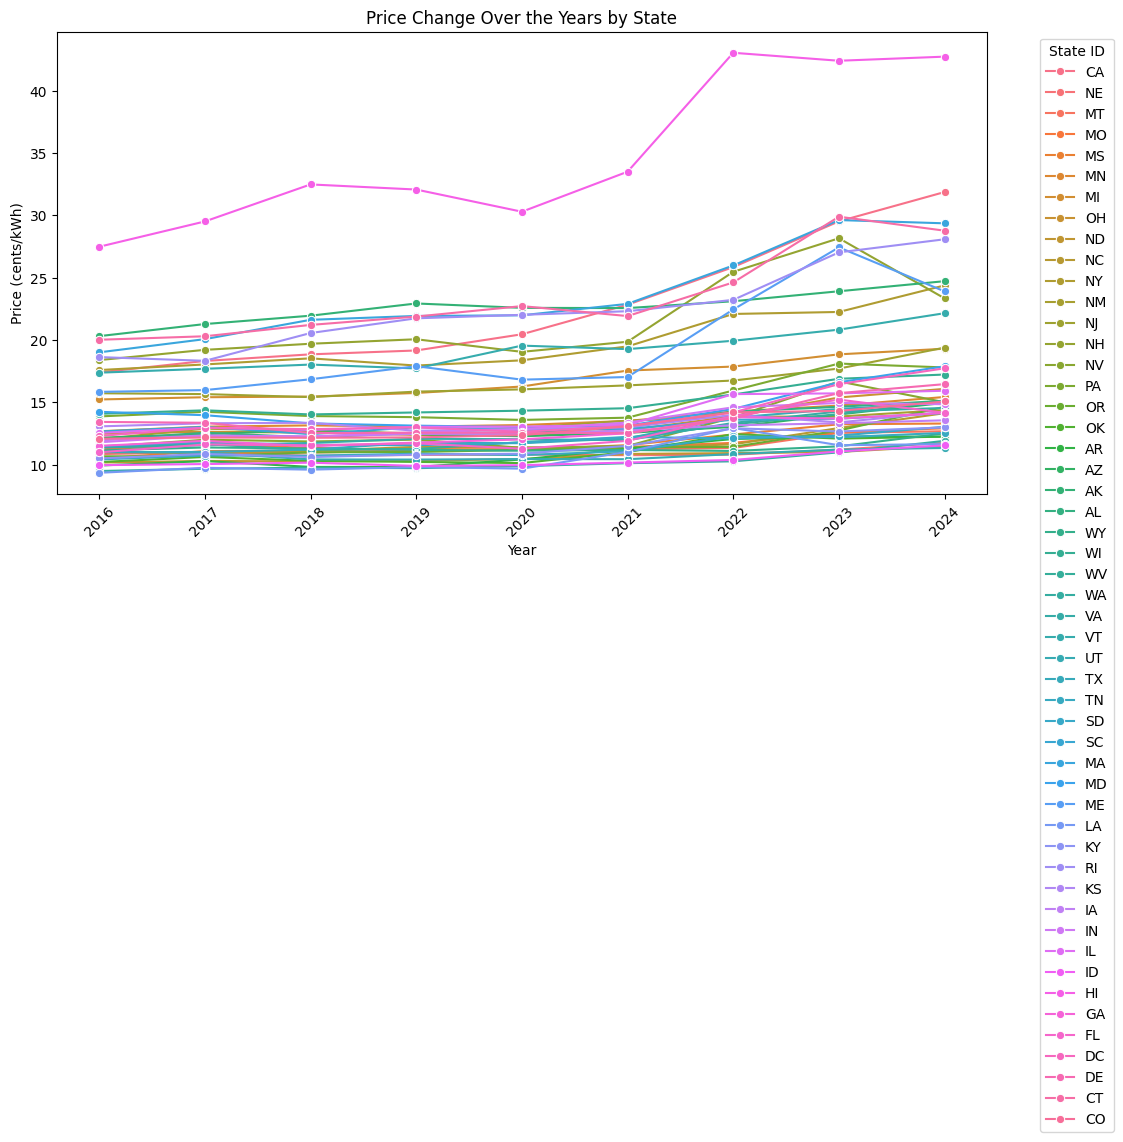

In [414]:
# Visualizing price change over the years
plt.figure(figsize=(12, 6))
sns.lineplot(data=electricity_df, x='year', y='price(cents/kWh)', hue='stateid', marker='o')
plt.title('Price Change Over the Years by State')
plt.xlabel('Year')
plt.ylabel('Price (cents/kWh)')
plt.xticks(rotation=45)
plt.legend(title='State ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Shown above we can see how price per KWH has changed over the years from 2016 to 2024. It is notable that all states (including the Distric of Columbia) has seen an increase in electricity cost over this 9 year time period. The average price increase for all states is 20.51% Interestingly prices across all states have seen an accelerated increase in prices starting at about 2021. 

#### Correlations between Variables

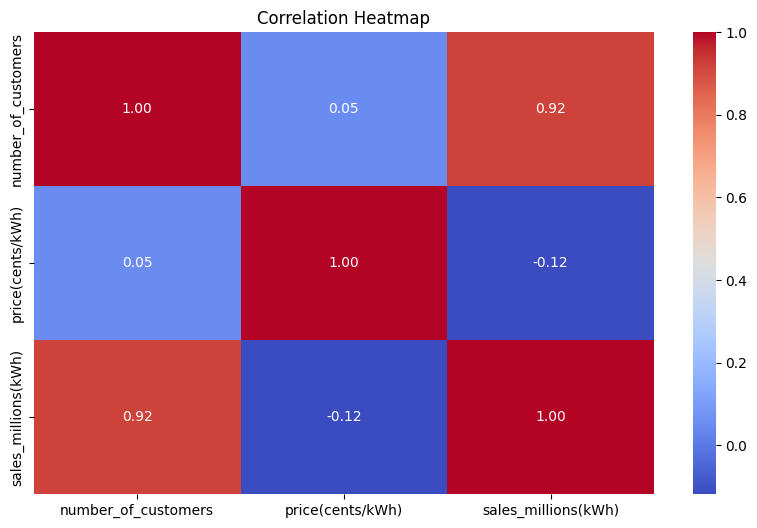

In [415]:
# Creating correlation heatmap
plt.figure(figsize=(10, 6))
correlation_matrix = electricity_df[['number_of_customers', 'price(cents/kWh)', 'sales_millions(kWh)']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


The correlation heatmap above reaffirms that as the number of customers increases the amount of kWh being sold increases as well with a strong positive correlation (0.92). The number of customers per state has very little correlation with price (0.05), and the price is only slightly negatively correlated with the amount of sales (-0.12).  

In [416]:
# Showing states with the highest increase in price
highest_price_increase = price_change.sort_values(by='price_change', ascending=False)
print("States with the highest increase in price:")
print(highest_price_increase[['stateid', 'price_change']].head(15))

States with the highest increase in price:
   stateid  price_change
11      HI         15.25
4       CA         14.47
19      MA         10.35
39      RI          9.45
6       CT          8.75
21      ME          8.06
34      NY          6.79
7       DC          5.43
30      NH          4.95
46      VT          4.77
0       AK          4.41
22      MI          4.07
37      OR          3.97
43      TX          3.95
38      PA          3.93


In [417]:
# Showing states with the highest price in 2024
highest_price_2024 = electricity_df[electricity_df['year'] == 2024].sort_values(by='price(cents/kWh)', ascending=False)
print("States with the highest price in 2024:")
print(highest_price_2024[['stateid', 'price(cents/kWh)']].head(15))

States with the highest price in 2024:
   stateid  price(cents/kWh)
44      HI             42.72
0       CA             31.86
33      MA             29.35
49      CT             28.76
38      RI             28.07
20      AK             24.71
10      NY             24.37
35      ME             23.89
13      NH             23.33
27      VT             22.14
12      NJ             19.38
6       MI             19.29
34      MD             17.88
15      PA             17.79
47      DC             17.72


# Data Analysis

Creating a class to run an OLS regression model on electricity price for a specified state, forecast the next 30 years, and plot the cumulative electricity spend (based on the OLS predictions) for an individual within the state. Example usage of this class will be shown with NJ.

In [418]:
# Creating a class for OLS regression and forecasting for a specific state

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

class ElectricityOLS:
    def __init__(self, df, state, upfront_cost):
        # Initialize class with dataframe, state, and upfront cost of solar panels
        self.df = df[df['stateid'] == state].copy() # Filter data for the specific state
        self.state = state
        self.upfront_cost = upfront_cost  # Upfront cost of solar panels
        self.df.set_index('year', inplace=True)  # Ensure 'year' is the index
        self.df.sort_index(inplace=True)  # Sort for time series consistency

        # Initialize model and predictions
        self.model = None
        self.predictions = None
        self.future_df = None

    def run_OLS(self):
       # Run OLS regression 
        self.df['time'] = np.arange(len(self.df))  # Create a time variable
        X = sm.add_constant(self.df['time'])  # Add intercept
        y = self.df['price(cents/kWh)'] # Dependent variable
        
        # Fit OLS model
        self.model = sm.OLS(y, X).fit()
        
        # Generate historical predictions
        self.df['fitted_values'] = self.model.predict(X)
        return self.model.summary()

    def forecast_next_30_years(self):
        # Generating 30 years forcast
        last_time = len(self.df)  # Get last time index
        future_years = np.arange(last_time, last_time + 30)  # Create future time steps
        future_X = sm.add_constant(future_years)  # Add intercept for future predictions
        
        # Predict future prices
        self.predictions = self.model.predict(future_X)
        
        # Create forecast dataframe
        self.future_df = pd.DataFrame({'year': np.arange(self.df.index[-1] + 1, self.df.index[-1] + 31),
                                       'predicted_price': self.predictions})

        # Assume steady sales and customers based on last known values
        last_sales = self.df['sales_millions(kWh)'].iloc[-1]
        last_customers = self.df['number_of_customers'].iloc[-1]

        self.future_df['sales_millions(kWh)'] = last_sales
        self.future_df['number_of_customers'] = last_customers

        return self.future_df

    def plot_forecast(self):
        # Plotting the forecast
        plt.figure(figsize=(10, 5))
        plt.plot(self.df.index, self.df['price(cents/kWh)'], label="Historical Data", marker="o")
        plt.plot(self.df.index, self.df['fitted_values'], label="Fitted Model", linestyle="--")
        plt.plot(self.future_df['year'], self.future_df['predicted_price'], label="30-Year Forecast", linestyle="-.", color="red")

        plt.xlabel("Year")
        plt.ylabel("Price (cents/kWh)")
        plt.title(f"Electricity Price Forecast for {self.state}")
        plt.legend()
        plt.grid()
        plt.show()

    def plot_cumulative_spend_per_customer(self):
        # Plotting cumulative spend per customer and upfront cost to visualize the cost of solar panels

        # Calculate yearly spend in millions of dollars
        self.future_df['total_estimated_spend_millions'] = (self.future_df['predicted_price'] / 100) * self.future_df['sales_millions(kWh)']

        # Calculate per-customer spend
        self.future_df['estimated_spend_per_customer'] = (self.future_df['total_estimated_spend_millions'] * 1e6) / self.future_df['number_of_customers']

        # Compute cumulative spend per customer
        self.future_df['cumulative_spend_per_customer'] = self.future_df['estimated_spend_per_customer'].cumsum()

        # Plot cumulative spend per customer
        plt.figure(figsize=(10, 5))
        plt.plot(self.future_df['year'], self.future_df['cumulative_spend_per_customer'], label="Cumulative Estimated Spend per Customer", color="green", marker="o")
        
        # Add horizontal line for upfront cost
        plt.axhline(y=self.upfront_cost, color='red', linestyle='--', label="Upfront Cost")

        plt.xlabel("Year")
        plt.ylabel("Cumulative Spend per Customer (USD)")
        plt.title(f"Cumulative Electricity Spend Forecast per Customer in {self.state}")
        plt.legend()
        plt.grid()
        plt.show()

    def calculate_estimated_savings(self):
        # Calculate estimated savings based on the cumulative spend per customer and upfront cost: assuming electricity usage remains constant
        
        # Final cumulative spend per customer after 30 years
        final_spend_per_customer = self.future_df['cumulative_spend_per_customer'].iloc[-1]

        # Calculate savings as difference between upfront cost and future total spend
        estimated_savings = final_spend_per_customer - self.upfront_cost

        return estimated_savings

                            OLS Regression Results                            
Dep. Variable:       price(cents/kWh)   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                     19.65
Date:                Sun, 18 May 2025   Prob (F-statistic):            0.00303
Time:                        15:34:51   Log-Likelihood:                -8.3962
No. Observations:                   9   AIC:                             20.79
Df Residuals:                       7   BIC:                             21.19
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.9400      0.429     34.853      0.0

c:\Users\chung\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=9 observations were given.
  return hypotest_fun_in(*args, **kwds)


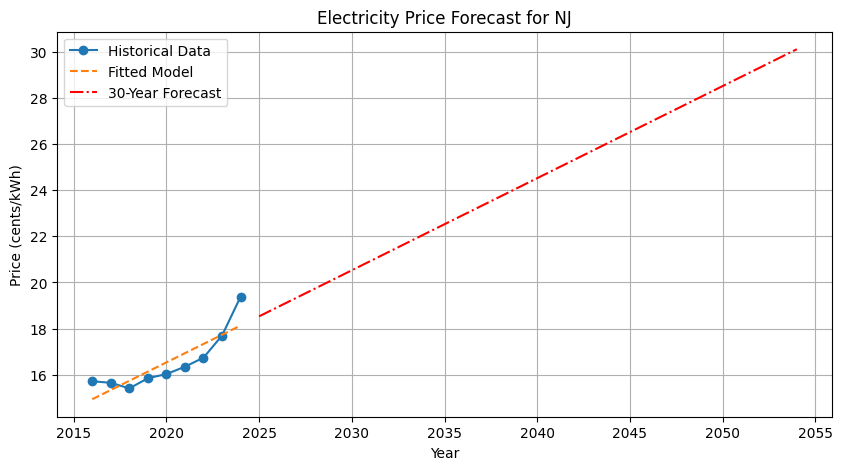

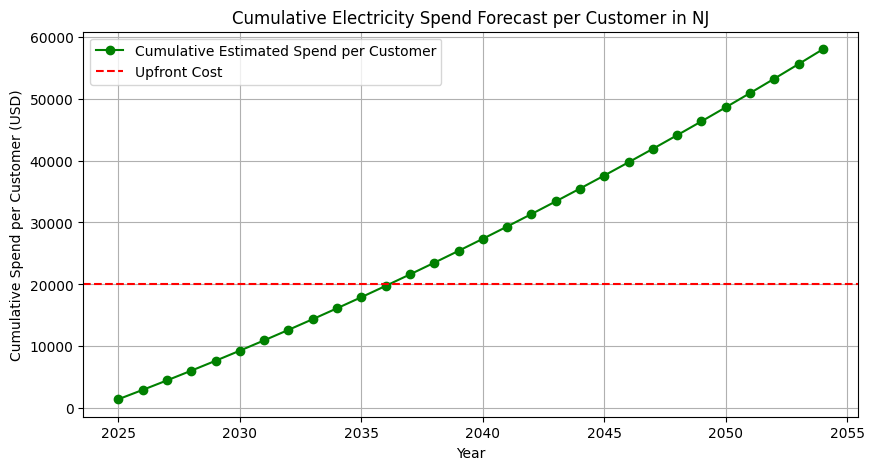

Estimated savings over 30 years for NJ: $37964.07
Estimated savings as a percentage of upfront cost: 189.82%


In [419]:
# Example usage of class for NJ, with an upfront cost of $20,000 for solar panels

predictor = ElectricityOLS(electricity_df, state="NJ", upfront_cost=20000)

# Run OLS model
print(predictor.run_OLS())

# Generate 30-year forecast
predictor.forecast_next_30_years()

# Plot price forecast
predictor.plot_forecast()

# Plot cumulative estimated spend per customer (with upfront cost)
predictor.plot_cumulative_spend_per_customer()

# Calculate estimated savings
savings = predictor.calculate_estimated_savings()
print(f"Estimated savings over 30 years for {predictor.state}: ${savings:.2f}")

# Calculate estimated savings as a percentage of upfront cost
savings_percentage = (savings / predictor.upfront_cost) * 100
print(f"Estimated savings as a percentage of upfront cost: {savings_percentage:.2f}%")

In [420]:
# Calculating return on investment if upfront cost is placed into a S&P 500 index fund with a 7% CAGR

def calculate_roi(upfront_cost, annual_rate_of_return, years):
    # Calculate future value of investment
    future_value = upfront_cost * ((1 + annual_rate_of_return) ** years)
    return future_value

# Example usage
upfront_cost = 20000  # Upfront cost of solar panels
annual_rate_of_return = 0.07  # 7% annual return
years = 30  # Investment period in years
future_value = calculate_roi(upfront_cost, annual_rate_of_return, years)
print(f"Future value of upfront cost in S&P 500 index fund after {years} years: ${roi:.2f}")

roi = future_value - upfront_cost
print(f"ROI from S&P 500 index fund after {years} years: ${roi:.2f}")

# Calculate ROI of S&P as a percentage of upfront cost
roi_percentage = (roi / upfront_cost) * 100
print(f"ROI as a percentage of upfront cost: {roi_percentage:.2f}%")



Future value of upfront cost in S&P 500 index fund after 30 years: $132245.10
ROI from S&P 500 index fund after 30 years: $132245.10
ROI as a percentage of upfront cost: 661.23%


# Conclusion

- Electricity prices for all states were found to increase over the 9 year time period of the data.
- Electricity usage was found not to be significantly correlated to the price per kWh, instead is likely correlated to external factors outside of this study such as climate of the particular state, or individual inclination to electronics usage.

- The investment in solar panels provides a significant return above 150% of upfront cost for the vast majority of states in the United States over a 30 year period. 
- The investment in the ideal case for the S&P 500 of 7% CAGR provides a greater return of 761.23% of upfront cost over a 30 year period. 
 
- This study has found that solar panels can be a significant source of investment ROI, although the ROI into the S&P 500 ideal case is significantly greater. The use-case for solar panels as a financial investment would make most sense as a diversification tool to reduce stock market exposure. This is because the S&P 500 ideal case has innate uncertainty whereas electricity usage is a necessity which is seen through this study to only become more and more expensive as time progresses.